In [2]:
import numpy as np
import pickle
import pandas as pd
from datetime import datetime
from tqdm import tqdm

def time_difference(time1, time2):
    """Calculate time difference in minutes"""
    t1 = datetime.strptime(time1, "%H:%M:%S")
    t2 = datetime.strptime(time2, "%H:%M:%S")
    return abs((t2 - t1).total_seconds() / 60)

def create_graph_from_csv(path):
    df = pd.read_csv(path)
    graph = {}

    # First pass: Create all nodes and initialize with empty neighbor dictionaries
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Creating nodes"):
        quay_id = row['Quay ID']
        if quay_id not in graph:
            graph[quay_id] = {
                'neighbors': {},
                'quay_name': row['Quay Name'],
                'quay_private_code': row['Quay Private Code'],
                'quay_latitude': row['Quay Latitude'],
                'quay_longitude': row['Quay Longitude'],
                'stop_place_id': row['StopPlace ID'],
                'stop_place_name': row['StopPlace Name'],
                'stop_place_private_code': row['StopPlace Private Code'],
                'stop_place_latitude': row['StopPlace Latitude'],
                'stop_place_longitude': row['StopPlace Longitude']
            }

    # Second pass: Add connections
    grouped = df.groupby('Route_ID')
    for route_id, route_df in tqdm(grouped, total=len(grouped), desc="Processing routes"):
        route_df = route_df.sort_values('Order')
        
        for i in range(len(route_df) - 1):
            current_stop = route_df.iloc[i]
            next_stop = route_df.iloc[i+1]
            
            current_id = current_stop['Quay ID']
            next_id = next_stop['Quay ID']
            
            if current_id != next_id:  # Avoid self-loops
                if next_id not in graph[current_id]['neighbors']:
                    graph[current_id]['neighbors'][next_id] = {
                        'travel_time': float('inf'), 
                        'route_ids': set(),
                        'transport_mode': current_stop['TransportMode']
                    }
                
                if pd.notnull(current_stop['DepartureTime']) and pd.notnull(next_stop['ArrivalTime']):
                    travel_time = time_difference(current_stop['DepartureTime'], next_stop['ArrivalTime'])
                    # Update travel time if it's shorter than the existing one
                    if travel_time < graph[current_id]['neighbors'][next_id]['travel_time']:
                        graph[current_id]['neighbors'][next_id]['travel_time'] = travel_time
                
                # Add the route_id to the set of routes connecting these stops
                graph[current_id]['neighbors'][next_id]['route_ids'].add(route_id)

    return graph

# Usage
path = "routes_master_data.csv"
graph = create_graph_from_csv(path)

print("Sample of the graph:")
print(list(graph.items())[:1])

/Users/sunandclouds/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Processing routes: 100%|██████████| 3150/3150 [02:40<00:00, 19.64it/s] 

Sample of the graph:
[(9022001064146002, {'neighbors': {9022001064894002: {'travel_time': 295.25, 'route_ids': {14010000257325269}, 'transport_mode': 'bus'}, 9022001062571002: {'travel_time': 0.6166666666666667, 'route_ids': {14010000668408490, 14010000563315326, 14010000664752559}, 'transport_mode': 'bus'}}, 'quay_name': 'Campus Roslagen', 'quay_private_code': 2, 'quay_latitude': 59.748264, 'quay_longitude': 18.685736, 'stop_place_id': 9021001064146000, 'stop_place_name': 'Campus Roslagen', 'stop_place_private_code': 64146, 'stop_place_latitude': 59.748096, 'stop_place_longitude': 18.685677})]


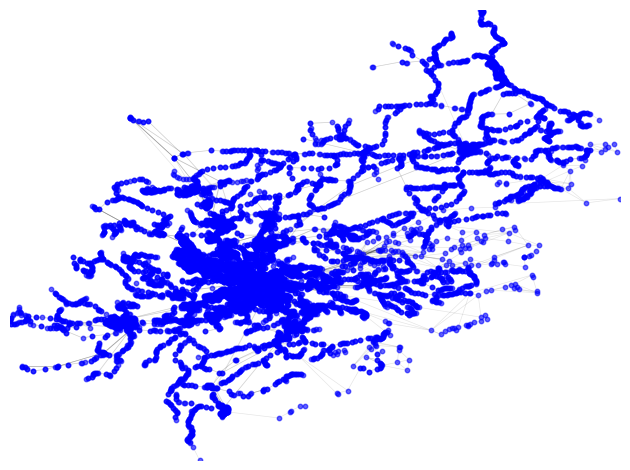

In [3]:
import networkx as nx
from numba import njit
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def visualize_graph(graph, node_size=10, edge_alpha=0.1):
    # Create a NetworkX graph from the dictionary
    G = nx.Graph()
    
    # Add nodes
    regular_stops = []
    quay_stops = []
    for node, data in graph.items():
        G.add_node(node, pos=(data['quay_longitude'], data['quay_latitude']))
        if 'quay' in data['stop_place_name'].lower():
            quay_stops.append(node)
        else:
            regular_stops.append(node)
    
    # Add edges
    for node, data in graph.items():
        for neighbor, edge_data in data['neighbors'].items():
            G.add_edge(node, neighbor, weight=edge_data['travel_time'])
    
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Draw edges
    edges = G.edges()
    edge_collection = LineCollection(
        [np.array([pos[u], pos[v]]) for u, v in edges],
        colors='black',
        linewidths=0.5,
        alpha=edge_alpha,
        zorder=1
    )
    plt.gca().add_collection(edge_collection)
    
    # Draw regular stops
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=regular_stops,
        node_size=node_size,
        node_color='blue',
        alpha=0.6,
    )
    
    # Draw quay stops
    #nx.draw_networkx_nodes(
    #    G, pos,
    #    nodelist=quay_stops,
    #    node_size=node_size*1.5,  # Make quay stops slightly larger
    #    node_color='red',
    #    alpha=0.6,
    #)
    
    # Set axis limits
    plt.xlim(min(x for x, _ in pos.values()), max(x for x, _ in pos.values()))
    plt.ylim(min(y for _, y in pos.values()), max(y for _, y in pos.values()))
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("graph.png", dpi=300, bbox_inches='tight')
    plt.show()

# Assuming 'graph' is your dictionary graph
visualize_graph(graph)